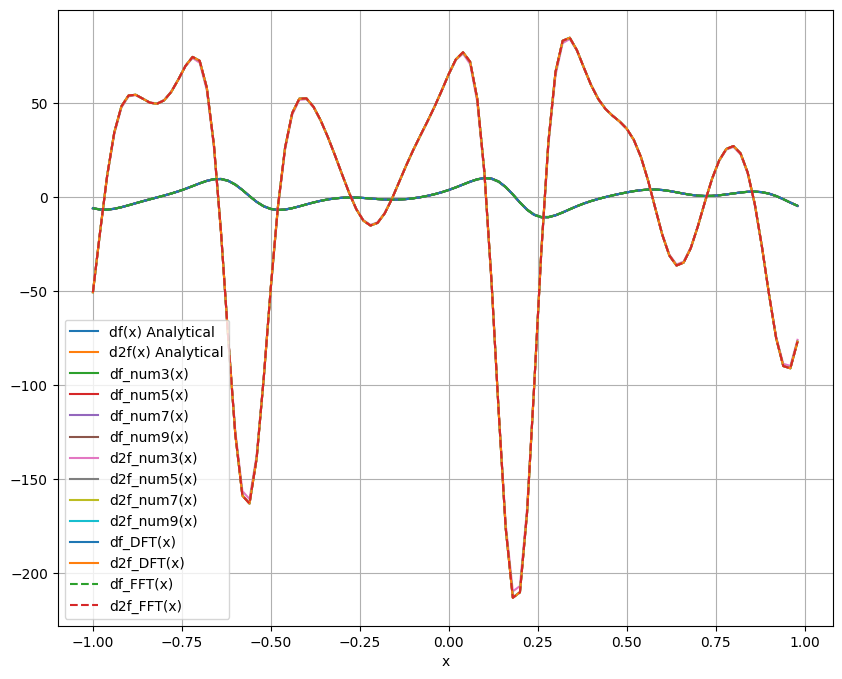

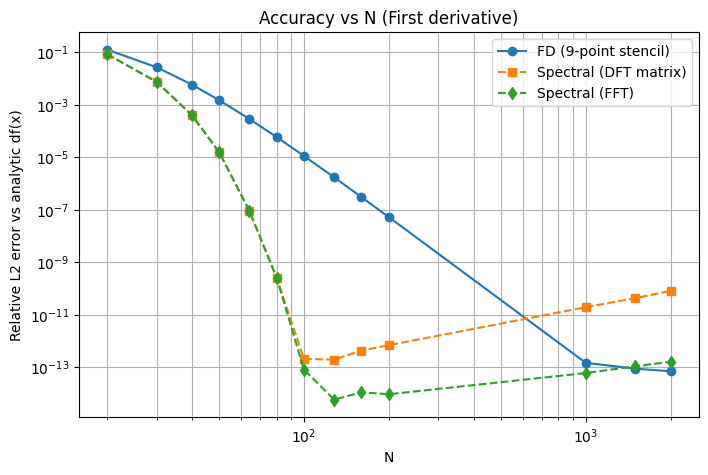

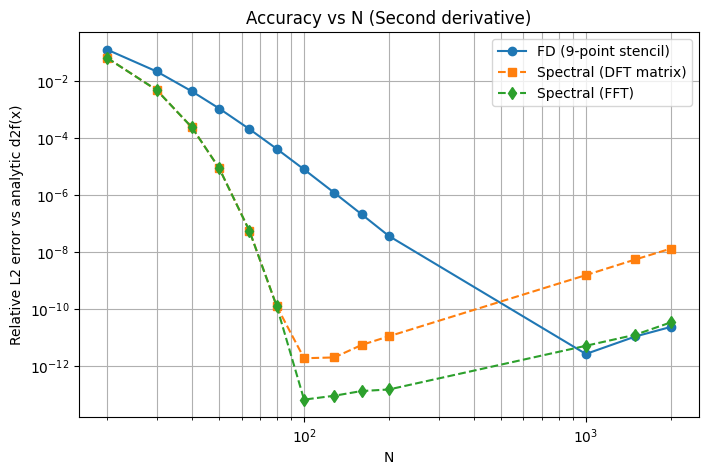

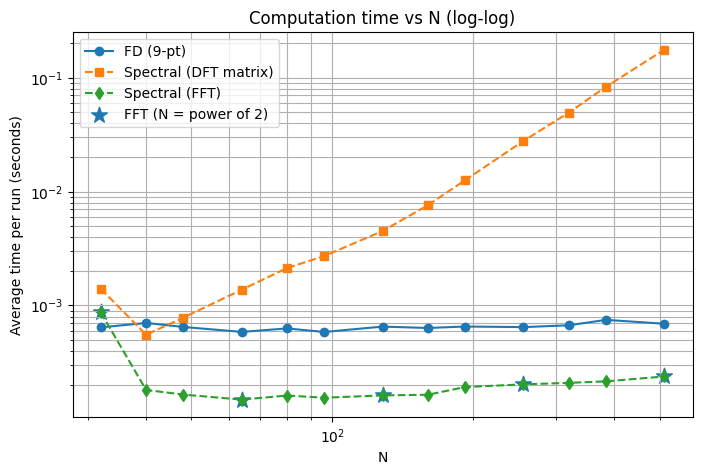

   N   pow2   t_FD(s)     t_DFT(s)     t_FFT(s)
  32   True   6.420e-04   1.400e-03   8.688e-04
  40  False   7.021e-04   5.535e-04   1.813e-04
  48  False   6.477e-04   7.812e-04   1.652e-04
  64   True   5.861e-04   1.374e-03   1.491e-04
  80  False   6.286e-04   2.130e-03   1.620e-04
  96  False   5.853e-04   2.711e-03   1.550e-04
 128   True   6.522e-04   4.504e-03   1.623e-04
 160  False   6.344e-04   7.589e-03   1.646e-04
 192  False   6.536e-04   1.257e-02   1.923e-04
 256   True   6.454e-04   2.782e-02   2.030e-04
 320  False   6.698e-04   4.931e-02   2.092e-04
 384  False   7.474e-04   8.297e-02   2.157e-04
 512   True   6.913e-04   1.761e-01   2.381e-04


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Defining a box from -L to +L with a certain number of points N. This is called discretization.
N = 100
L = 1
x = np.linspace(-L, L, N, endpoint=False)
dx = x[1] - x[0]

# Defining the function that we want to take the derivative of.
f = np.exp((np.sin(3*np.pi*x)/2) - (np.cos(5*np.pi*x)/4))

# The First question asks us to find the analytic expression for the first and second derivatives.
# I prefer defining a function and returning the value.

def df(x):
    return np.exp((np.sin(3*np.pi*x)/2) - (np.cos(5*np.pi*x)/4)) * ((3*np.pi/2)*np.cos(3*np.pi*x) + (5*np.pi/4)*np.sin(5*np.pi*x))
       
def d2f(x):
    return (((1.5 * np.pi * np.cos(np.pi * 3 * x)) + (1.25 * np.pi * np.sin(5 * x * np.pi)))**2 - (4.5 * np.pi ** 2 * np.sin(3 * x * np.pi)) + (6.25 * np.pi**2 * np.cos(5 * x * np.pi))) * np.exp((np.sin(np.pi*3*x)/2) - (np.cos(np.pi*5*x)/4))

# Q2 wants us to derive numerically the first and second derivatives using finite difference method.
# we are going to use 3, 5, 7, and 9 point stencils to compute the numerical derivatives.

def num_der(f, dx, order, stencil):
    A = []
    d = np.zeros((len(stencil), 1))
    for n in range(len(stencil)):
        A.append(stencil ** n)
    A  = np.array(A)
   
    d[order] = math.factorial(order) 
    c = np.linalg.solve(A, d)
    a = [np.roll(f, -i) for i in stencil]
    g = np.dot(c.flatten(), a) / (dx ** order)
    return g, c

# Define the stencils for 3, 5, 7, and 9 points
stencil3 = np.array([-1, 0, 1,]) # we could have defined like [-1, 1) and using np.arrange
stencil5 = np.array([-2, -1, 0, 1, 2])
stencil7 = np.array([-3, -2, -1, 0, 1, 2, 3])
stencil9 = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])

# Compute the derivative

order = 1

df_num3, c1_3 = num_der(f, dx, order, stencil3)
df_num5, c1_5 = num_der(f, dx, order, stencil5)
df_num7, c1_7 = num_der(f, dx, order, stencil7)
df_num9, c1_9 = num_der(f, dx, order, stencil9)
# c1_3: constants for the 3 point stencil when we want to take the first order derivative and so on.

order = 2
d2f_num3, c2_3 = num_der(f, dx, order, stencil3)
d2f_num5, c2_5 = num_der(f, dx, order, stencil5)
d2f_num7, c2_7 = num_der(f, dx, order, stencil7)
d2f_num9, c2_9 = num_der(f, dx, order, stencil9)
# c2_3: constants for the 3 point stencil when we want to take the second order derivative and so on.

# Calculate the derivative df using the spectral method (using the DFT matrix)

def dft_matrix(N):
    j = np.arange(N).reshape(N, 1)
    k = np.arange(N).reshape(1, N)
    return np.exp(-2j * np.pi * j * k / N)

def spectral_diff_matrices(N, L):
    F = dft_matrix(N)
    Finv = np.conj(F).T / N

    if N % 2 == 0:
        kk = np.concatenate((np.arange(0, N//2), np.arange(-N//2, 0)))
    else:
        kk = np.concatenate((np.arange(0, (N-1)//2 + 1), np.arange(-(N-1)//2, 0)))

    k = (2*np.pi/L) * kk  # radians per unit x

    D1 = Finv @ np.diag(1j * k) @ F
    D2 = Finv @ np.diag(-(k**2)) @ F
    return D1, D2

D1, D2 = spectral_diff_matrices(N, L=2*L)
df_DFT = (D1 @ f).real
d2f_DFT = (D2 @ f).real


# Calculate the derivative df using the FFT (Fast Fourier Transform)
def fft_derivative(f, dx, order):
    N = len(f)
    k = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    f_hat = np.fft.fft(f)
    df_hat = (1j * k) ** order * f_hat
    df = np.fft.ifft(df_hat).real
    return df
df_fft = fft_derivative(f, dx, 1)
d2f_fft = fft_derivative(f, dx, 2)


# Plotting the results
figsize = (10, 8)
plt.figure(figsize=figsize)

#plt.plot(x, f)
plt.plot(x, df(x), label='df(x) Analytical')
plt.plot(x, d2f(x), label='d2f(x) Analytical')
plt.plot(x, df_num3, label='df_num3(x)')
plt.plot(x, df_num5, label='df_num5(x)')
plt.plot(x, df_num7, label='df_num7(x)')
plt.plot(x, df_num9, label='df_num9(x)')
plt.plot(x, d2f_num3, label='d2f_num3(x)')
plt.plot(x, d2f_num5, label='d2f_num5(x)')
plt.plot(x, d2f_num7, label='d2f_num7(x)')
plt.plot(x, d2f_num9, label='d2f_num9(x)')
plt.plot(x, df_DFT, label='df_DFT(x)')
plt.plot(x, d2f_DFT,  label='d2f_DFT(x)')
plt.plot(x, df_fft, '--', label='df_FFT(x)')
plt.plot(x, d2f_fft, '--',label='d2f_FFT(x)')
plt.xlabel('x')
plt.grid()
plt.legend()
plt.show()


# Q5: Log-log plot: accuracy vs N for the three methods
# FD using stencil9, Spectral DFT-matrix, Spectral FFT
# Errors computed w.r.t analytic df(x) and d2f(x)

N_list = np.array([20, 30, 40, 50, 64, 80, 100, 128, 160, 200, 1000, 1500, 2000]) # I put 1500 and 2000 to see the error at higher N, but you can remove them if you want. it will reduce the computational cost significantly.

err_df_FD  = []
err_df_DFT = []
err_df_FFT = []

err_d2_FD  = []
err_d2_DFT = []
err_d2_FFT = []

Ldom = 2*L  # because the grid is [-L, L)

for Nn in N_list:
    xN = np.linspace(-L, L, Nn, endpoint=False)
    dxN = xN[1] - xN[0]

    fN = np.exp((np.sin(3*np.pi*xN)/2) - (np.cos(5*np.pi*xN)/4))

    # analytic derivatives (ground truth)
    df_ex  = df(xN)
    d2f_ex = d2f(xN)

    # ---------- Finite Difference (use your 9-point stencil) ----------
    df_fd,  _ = num_der(fN, dxN, 1, stencil9)
    d2f_fd, _ = num_der(fN, dxN, 2, stencil9)

    # ---------- Spectral DFT-matrix ----------
    D1N, D2N = spectral_diff_matrices(Nn, L=Ldom)
    df_dft  = (D1N @ fN).real
    d2f_dft = (D2N @ fN).real

    # ---------- Spectral FFT ----------
    df_fftN  = fft_derivative(fN, dxN, 1)
    d2f_fftN = fft_derivative(fN, dxN, 2)

    # ---------- Relative L2 error ----------
    err_df_FD.append(  np.linalg.norm(df_fd   - df_ex)  / np.linalg.norm(df_ex)  )
    err_df_DFT.append( np.linalg.norm(df_dft  - df_ex)  / np.linalg.norm(df_ex)  )
    err_df_FFT.append( np.linalg.norm(df_fftN - df_ex)  / np.linalg.norm(df_ex)  )

    err_d2_FD.append(  np.linalg.norm(d2f_fd   - d2f_ex) / np.linalg.norm(d2f_ex) )
    err_d2_DFT.append( np.linalg.norm(d2f_dft  - d2f_ex) / np.linalg.norm(d2f_ex) )
    err_d2_FFT.append( np.linalg.norm(d2f_fftN - d2f_ex) / np.linalg.norm(d2f_ex) )

err_df_FD  = np.array(err_df_FD)
err_df_DFT = np.array(err_df_DFT)
err_df_FFT = np.array(err_df_FFT)

err_d2_FD  = np.array(err_d2_FD)
err_d2_DFT = np.array(err_d2_DFT)
err_d2_FFT = np.array(err_d2_FFT)

#Plot First derivative accuracy -----------------
plt.figure(figsize=(8,5))
plt.loglog(N_list, err_df_FD,  'o-', label='FD (9-point stencil)')
plt.loglog(N_list, err_df_DFT, 's--', label='Spectral (DFT matrix)')
plt.loglog(N_list, err_df_FFT, 'd--', label='Spectral (FFT)')
plt.grid(True, which='both')
plt.xlabel('N')
plt.ylabel('Relative L2 error vs analytic df(x)')
plt.title('Accuracy vs N (First derivative)')
plt.legend()
plt.show()

#Plotting Second derivative accuracy -
plt.figure(figsize=(8,5))
plt.loglog(N_list, err_d2_FD,  'o-', label='FD (9-point stencil)')
plt.loglog(N_list, err_d2_DFT, 's--', label='Spectral (DFT matrix)')
plt.loglog(N_list, err_d2_FFT, 'd--', label='Spectral (FFT)')
plt.grid(True, which='both')
plt.xlabel('N')
plt.ylabel('Relative L2 error vs analytic d2f(x)')
plt.title('Accuracy vs N (Second derivative)')
plt.legend()
plt.show()


#  Log-log plot: computation time vs N for three methods
#  FD (9-pt), Spectral DFT-matrix, Spectral FFT
#  hand check if FFT is faster at N = power of 2


import time

# Choose N values (include powers of 2 and non-powers)
N_list_time = np.array([32, 40, 48, 64, 80, 96, 128, 160, 192, 256, 320, 384, 512])

# number of repeats for timing (increase if your timings are noisy)
nrep = 20

t_FD  = []
t_DFT = []
t_FFT = []

Ldom = 2*L  # domain length for x in [-L, L)

def is_power_of_two(n):
    return (n & (n - 1) == 0) and n > 0

for Nn in N_list_time:
    xN = np.linspace(-L, L, Nn, endpoint=False)
    dxN = xN[1] - xN[0]
    fN = np.exp((np.sin(3*np.pi*xN)/2) - (np.cos(5*np.pi*xN)/4))

    # ---------- FD timing (9-point stencil) ----------
    start = time.perf_counter()
    for _ in range(nrep):
        df_fd, _  = num_der(fN, dxN, 1, stencil9)
        d2f_fd, _ = num_der(fN, dxN, 2, stencil9)
    end = time.perf_counter()
    t_FD.append((end - start) / nrep)

    # ---------- DFT-matrix spectral timing ----------
    start = time.perf_counter()
    for _ in range(nrep):
        D1N, D2N = spectral_diff_matrices(Nn, L=Ldom)  # includes matrix build cost
        df_dft  = (D1N @ fN).real
        d2f_dft = (D2N @ fN).real
    end = time.perf_counter()
    t_DFT.append((end - start) / nrep)

    # ---------- FFT spectral timing ----------
    start = time.perf_counter()
    for _ in range(nrep):
        df_fftN  = fft_derivative(fN, dxN, 1)
        d2f_fftN = fft_derivative(fN, dxN, 2)
    end = time.perf_counter()
    t_FFT.append((end - start) / nrep)

t_FD  = np.array(t_FD)
t_DFT = np.array(t_DFT)
t_FFT = np.array(t_FFT)

# Separate power-of-two points for highlighting
pow2_mask = np.array([is_power_of_two(int(n)) for n in N_list_time])

# ----------------- Plot runtimes (log-log) -----------------
plt.figure(figsize=(8,5))
plt.loglog(N_list_time, t_FD,  'o-', label='FD (9-pt)')
plt.loglog(N_list_time, t_DFT, 's--', label='Spectral (DFT matrix)')
plt.loglog(N_list_time, t_FFT, 'd--', label='Spectral (FFT)')

# Highlight FFT at powers of 2
plt.scatter(N_list_time[pow2_mask], t_FFT[pow2_mask], marker='*', s=140,
            label='FFT (N = power of 2)')

plt.grid(True, which='both')
plt.xlabel('N')
plt.ylabel('Average time per run (seconds)')
plt.title('Computation time vs N (log-log)')
plt.legend()
plt.show()

print("   N   pow2   t_FD(s)     t_DFT(s)     t_FFT(s)")
for n, p2, a, b, c in zip(N_list_time, pow2_mask, t_FD, t_DFT, t_FFT):
    print(f"{n:4d}  {str(p2):>5s}  {a:10.3e}  {b:10.3e}  {c:10.3e}")




